In [75]:
import os
import numpy as np
import torch
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import functools
import operator
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNN

## Utils to read and load image

In [76]:
cell_mask_dir = '../data/hpa_cell_mask'    
ROOT = '../data/'
train_or_test = 'train'

def read_img(image_id, color, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.dtype == 'uint16':
        img = (img/256).astype('uint8')
    return img

# image loader, using rgb only here
def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    red = read_img(image_id, "red", train_or_test, image_size)
    green = read_img(image_id, "green", train_or_test, image_size)
    blue = read_img(image_id, "blue", train_or_test, image_size)
    #yellow = read_img(image_id, "yellow", train_or_test, image_size)
    stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
    return stacked_images

# print utility from public notebook
def print_masked_img(image_id, mask):
    img = load_RGBY_image(image_id, train_or_test,image_size=512)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.6)
    plt.title('Image + Mask')
    plt.axis('off')
    plt.show()
    
def load_mask(image_id):
    """Generate instance masks for an image.
    Returns:
    masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
    class_ids: a 1D array of class IDs of the instance masks.
    """
    # Read mask files from 
    cell_mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
    cell_mask = cv2.resize(cell_mask, dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    mask_ids = np.unique(cell_mask)
    #find number of cells in the image
    return cell_mask

## Defining Dataset

In [77]:
class HPADataset(object):
    def __init__(self, root, csv, transforms=None):
        self.img_dir = os.path.join(root, 'train')
        self.mask_dir = os.path.join(root, 'hpa_cell_mask')
        self.transforms = transforms
        
        self.df = pd.read_csv(csv)
        
        #dropping this image since it has no masks
        self.df.drop(self.df[self.df['ID']=='940f418a-bba4-11e8-b2b9-ac1f6b6435d0'].index, inplace = True)  
        
        self.imgs = list(self.df['ID'])[:50]  
        
        #image class
        self.classes = self.df['Label'].values[:50] +1 
    
    def __getitem__(self, idx):
        
        # load images and masks
        img = self.load_RGBY_image(self.img_dir, self.imgs[idx], image_size=512)
        img = Image.fromarray(np.uint8(img))
        
        masks, obj_ids = self.load_mask(self.imgs[idx])
     
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
       
        boxes = []
        labels = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(self.classes[idx]))
       
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if len(boxes) == 0:
            print(self.imgs[idx], boxes.shape)
  
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
       
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target, self.imgs[idx]

    def __len__(self):
        return len(self.imgs)
    
    def read_img(self, path, image_id, color, image_size=None):
        filename = f'{path}/{image_id}_{color}.png'
        assert os.path.exists(filename), f'not found {filename}'
        img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        if image_size is not None:
            img = cv2.resize(img, (image_size, image_size))
        if img.dtype == 'uint16':
            img = (img/256).astype('uint8')
        return img

    # image loader, using rgb only here
    def load_RGBY_image(self, path, image_id, image_size=None):
        red = self.read_img(path, image_id, "red", image_size)
        green = self.read_img(path, image_id, "green", image_size)
        blue = self.read_img(path, image_id, "blue", image_size)

        stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
        return stacked_images
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # Read mask files from 
        masks = []
        class_ids = []
        cell_mask = np.load(f'{self.mask_dir}/{image_id}.npz')['arr_0']
        cell_mask = cv2.resize(cell_mask, dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
        
        #find number of cells in the image
        mask_ids = np.unique(cell_mask)

        #Remove background
        mask_ids = mask_ids[1:]
        
        #create binary mask for every cell in the image
        masks = cell_mask == mask_ids[:,None, None]

        return masks, mask_ids

## Defining and loading model from checkpoint

In [78]:
import torchvision.models._utils
from torchvision.models.detection.anchor_utils import AnchorGenerator

def get_densenet_maskrcnn(num_classes):
    backbone = torchvision.models.densenet121(pretrained = True)
    modules=list(backbone.children())[:-1]
    backbone=torch.nn.Sequential(*modules)
    backbone.out_channels=1024
    
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    model = MaskRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator)
    
    return model

In [79]:
from utils.engine import train_one_epoch, evaluate
import utils.utils
import utils.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.Normalize())
    else:
        transforms.append(T.Normalize())
    return T.Compose(transforms)

In [80]:
ROOT = '../data'
dataset_test = HPADataset(ROOT,csv='./data/test_split.csv', transforms=get_transform(train=False))

# define training and validation data loaders
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=6,
    collate_fn=utils.utils.collate_fn)


## Get predictions from model

In [81]:
def get_predictions(model, dataloader):
    predictions = []
    image_ids = []
    with torch.no_grad():
        for i, (images,target, ids) in enumerate(dataloader):
            image_ids.append(ids)
            images = list(image.to(device) for image in images)
            out = model(images)

            predictions.append(out)
            
    total_predictions = [x for m in predictions for x in m]
    image_ids = [x for m in image_ids for x in m]
    return total_predictions, image_ids


## Utils to process output from model and visualize the segmentation masks

In [82]:
classes = ['Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center',
            'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus', 'Intermediate filaments',
            'Actin filaments', 'Microtubules', 'Mitotic spindle', 'Centrosome', 'Plasma membrane', 'Mitochondria',
            'Aggresome', 'Cytosol', 'Vesicles and punctate cytosolic patterns', 'Negative']
class_names = {v: k for v, k in enumerate(classes)}

def get_outputs(prediction, threshold):
    
    # get all the scores
    scores = list(prediction['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    scores = scores[:thresholded_preds_count]
    # get the masks
    masks = (prediction['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in prediction['boxes'].detach().cpu().numpy()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    print(prediction['labels'])
    labels = [class_names[i.to(device).item()] for i in prediction['labels']]
    labels = labels[:thresholded_preds_count]
    return masks,scores, boxes, labels

In [83]:
import random
COLORS = np.random.uniform(0, 255, size=(20, 3))
def instance_segmentation_api(img, masks, boxes, labels, rect_th=1, text_size=0.75, text_th=1):
    for i in range(len(masks)):
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        rgb_mask = np.stack([red_map, green_map, blue_map], axis=2)
        
        img = cv2.addWeighted(img, 1, rgb_mask, 0.9, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,labels[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

In [84]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 20
# get the model using our helper function
model = get_densenet_maskrcnn(num_classes)
# move model to the right device
model.load_state_dict(torch.load('./checkpoints/densenet_bs16_single/model_14.pth',map_location=torch.device('cpu'))['model'])
model.to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(1

In [85]:
image_ids = pd.read_csv('./data/test_split.csv')['ID']
len(image_ids)

2083

In [86]:
predictions, image_ids = get_predictions(model, data_loader_test)

In [87]:
image = load_RGBY_image(image_ids[45], image_size=512)

In [88]:
masks,scores, boxes, labels = get_outputs(predictions[45],threshold=0.3)

tensor([ 8,  8,  8, 13,  3, 13, 14, 14,  8,  4, 14, 17, 17, 13, 13, 13, 17, 14,
        17,  6, 13, 14, 13, 13, 13, 18, 18,  1, 17, 17,  6,  8, 17, 13, 18, 18,
        13,  8,  8,  8, 18, 13, 18, 10,  1, 13, 14, 13, 13, 17, 17, 13, 15, 18,
        17, 14,  8, 18,  8, 18, 18, 13,  4,  1,  8, 17,  8, 14,  6,  9,  8,  4,
        13,  6, 13, 18,  8, 10, 18, 15, 13, 10,  8,  9,  2,  7, 18,  7,  8,  2,
        15,  6, 11, 17,  1,  7,  1, 17, 18, 14])


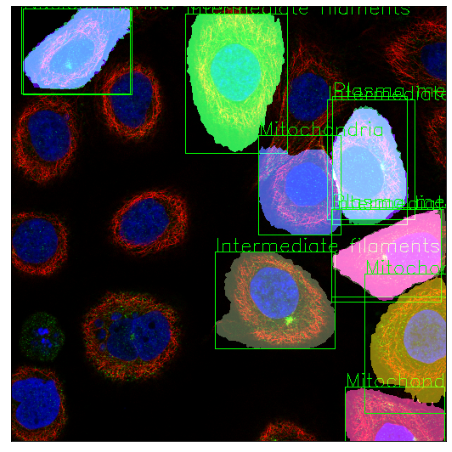

In [89]:
instance_segmentation_api(image, masks, boxes, labels)

### Visualize Feature Maps from last layer

In [34]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.backbone[0].denseblock4.denselayer16.conv2.register_forward_hook(get_activation('denselayer16'))
model.backbone[0].denseblock1.denselayer6.conv2.register_forward_hook(get_activation('denselayer6'))

In [35]:
with torch.no_grad():
    images,target,ids = next(iter(data_loader_test))
    images = list(image.to(device) for image in images)
    out = model(images)

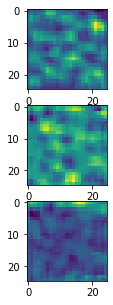

In [42]:
act = activation['denselayer16'].squeeze()[-3:]
fig, axarr = plt.subplots(act.size(0), figsize=(5,5))

for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx].cpu().numpy())

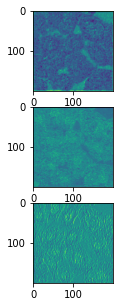

In [43]:
act = activation['denselayer6'].squeeze()[-3:]
fig, axarr = plt.subplots(act.size(0), figsize=(5,5))

for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx].cpu().numpy())